"""Ecommerce shipping prediction is the process of estimating the wheteher the product reached on time. which is  based on various factors such as the origin and destination of the package, the shipping method selected by the customer, the carrier used for shipping, and any potential delays or issues that may arise during the shipping process.
Machine learning models can be used to make accurate predictions about shipping times based on historical data and real-time updates from carriers. These models may take into account factors such as weather conditions, traffic, and other external factors that can impact delivery times.
Over All Ecommerce shipping prediction is an important tool for ecommerce businesses that want to provide accurate delivery estimates to their customers and improve their overall customer experience."""

# Importing the libraries Import the necessary libraries

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
import pickle as pkl

In [5]:
import numpy as np

In [6]:
from sklearn import svm

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,RidgeClassifier

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [12]:
from xgboost import XGBClassifier

In [13]:
from sklearn.preprocessing import Normalizer

In [14]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Loading data set

In [15]:
data = pd.read_csv("/content/Train.csv")
data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# Data Preparation

In [16]:
data.shape

(10999, 12)

In [17]:
#No null values found
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


For checking the null values, df.isnull() function is used. To sum those null values we use .sum() function. From the below image we found that there are no null values present in our dataset. So we can skip handling the missing values step.

In [18]:
data.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

# Label Mapping

In [19]:
label_map={}
for i in data.columns:
    if str(data[i].dtype) == 'object' :
        temp={}
        cats=data[i].unique()
        for index in range(len(cats)):
            temp[cats[index]]=index
        label_map[i]=temp
        #labeling
        data[i]=data[i].map(temp)
label_map

{'Warehouse_block': {'D': 0, 'F': 1, 'A': 2, 'B': 3, 'C': 4},
 'Mode_of_Shipment': {'Flight': 0, 'Ship': 1, 'Road': 2},
 'Product_importance': {'low': 0, 'medium': 1, 'high': 2},
 'Gender': {'F': 0, 'M': 1}}

# Handling Outliers in Data

With the help of boxplot, outliers are visualized.

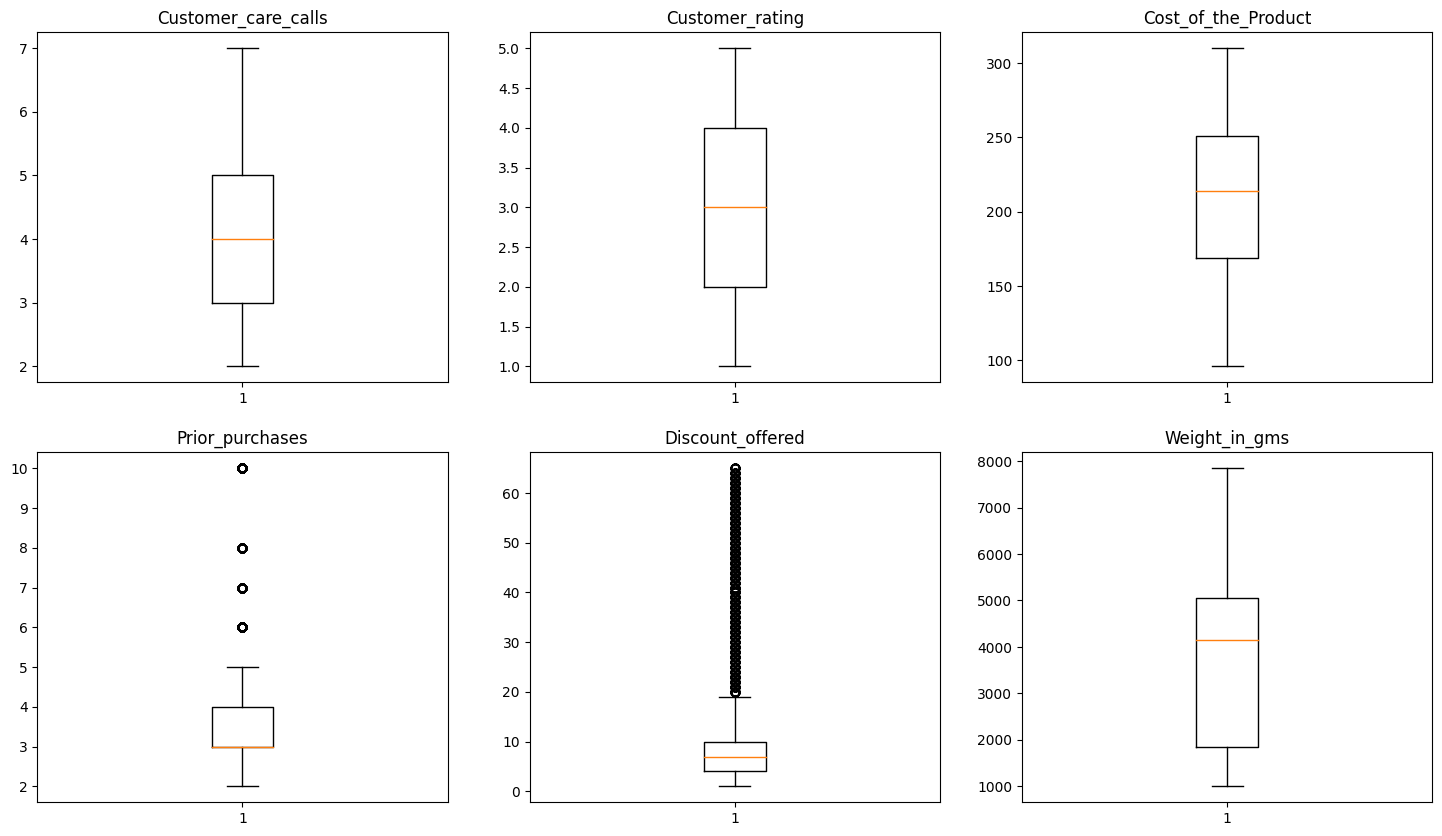

In [20]:
c=0
plt.figure(figsize=(18, 10))
for i in data.drop(columns=[
                            'Warehouse_block','Mode_of_Shipment','Product_importance','Gender','Reached.on.Time_Y.N','ID'
                           ]).columns:
    if str(data[i].dtype)=='object':
        continue
    plt.subplot(2, 3, c+1)
    plt.boxplot(data[i])
    plt.title(i)
    c+=1
plt.show()

In [21]:
def check_outliers(arr):
  Q1 = np.percentile(arr, 25,interpolation = 'midpoint')
  Q3 = np.percentile(arr, 75,interpolation = 'midpoint')
  IQR = Q3 - Q1

  #Above Upper bound
  upper=Q3+1.5*IQR
  upper_array=np.array(arr>=upper)
  print(' '*3,len(upper_array[upper_array == True]),'are over the upper bound:',upper)

  #Below lower bound
  lower=Q1-1.5*IQR
  lower_array=np.array(arr<=lower)
  print(' '*3,len(lower_array[lower_array == True]),'are less than the lower bound:',lower,'\n')

for i in data.drop(columns=[
                            'Warehouse_block','Mode_of_Shipment','Product_importance','Gender','Reached.on.Time_Y.N','ID'
                           ]).columns:
    if str(data[i].dtype)=='object':
        continue
    print(i)
    check_outliers(data[i])

Customer_care_calls
    0 are over the upper bound: 8.0
    0 are less than the lower bound: 0.0 

Customer_rating
    0 are over the upper bound: 7.0
    0 are less than the lower bound: -1.0 

Cost_of_the_Product
    0 are over the upper bound: 374.0
    0 are less than the lower bound: 46.0 

Prior_purchases
    1003 are over the upper bound: 5.5
    0 are less than the lower bound: 1.5 

Discount_offered
    2262 are over the upper bound: 19.0
    0 are less than the lower bound: -5.0 

Weight_in_gms
    0 are over the upper bound: 9865.75
    0 are less than the lower bound: -2976.25 



<ipython-input-21-f14ae62f04de>:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(arr, 25,interpolation = 'midpoint')
<ipython-input-21-f14ae62f04de>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(arr, 75,interpolation = 'midpoint')


# Descriptive Statistics

In [22]:
data.describe(include='all')

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,1.833167,0.998454,4.054459,2.990545,210.196836,3.567597,0.604600,0.495863,13.373216,3634.016729,0.596691
std,3175.28214,1.343823,0.567099,1.141490,1.413603,48.063272,1.522860,0.641464,0.500006,16.205527,1635.377251,0.490584
min,1.00000,0.000000,0.000000,2.000000,1.000000,96.000000,2.000000,0.000000,0.000000,1.000000,1001.000000,0.000000
25%,2750.50000,1.000000,1.000000,3.000000,2.000000,169.000000,3.000000,0.000000,0.000000,4.000000,1839.500000,0.000000
50%,5500.00000,1.000000,1.000000,4.000000,3.000000,214.000000,3.000000,1.000000,0.000000,7.000000,4149.000000,1.000000
75%,8249.50000,3.000000,1.000000,5.000000,4.000000,251.000000,4.000000,1.000000,1.000000,10.000000,5050.000000,1.000000
max,10999.00000,4.000000,2.000000,7.000000,5.000000,310.000000,10.000000,2.000000,1.000000,65.000000,7846.000000,1.000000


# Train test split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(
                                        data.drop(columns=['ID','Reached.on.Time_Y.N']),
                                        data['Reached.on.Time_Y.N'],
                                        random_state=1234,test_size = 0.20,
                                        shuffle=True
                                        )
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8799, 10)
(2200, 10)
(8799,)
(2200,)


# Training Function

In [24]:
def models_eval_mm(x_train, y_train, x_test, y_test):
    lg = LogisticRegression(random_state=1234)
    lg.fit(x_train,y_train)
    print('--Logistic Regression')
    print('Train Score:',lg.score(x_train,y_train))
    print('Test Score:',lg.score(x_test,y_test))
    print()

    lcv = LogisticRegressionCV(random_state=1234)
    lcv.fit(x_train,y_train)
    print('--Logistic Regression CV')
    print('Train Score:',lcv.score(x_train,y_train))
    print('Test Score:',lcv.score(x_test,y_test))
    print()

    print('--XGBoost')
    xgb = XGBClassifier(random_state=1234)
    xgb.fit(x_train,y_train)
    print('Train Score:',xgb.score(x_train,y_train))
    print('Test Score:',xgb.score(x_test,y_test))
    print()

    print('--Ridge Classifier')
    rg = RidgeClassifier(random_state=1234)
    rg.fit(x_train,y_train)
    print('Train Score:',rg.score(x_train,y_train))
    print('Test Score:',rg.score(x_test,y_test))
    print()

    print('--KNN')
    knn = KNeighborsClassifier()
    knn.fit(x_train,y_train)
    print('Train Score:',knn.score(x_train,y_train))
    print('Test Score:',knn.score(x_test,y_test))
    print()

    print('--Random Forest')
    rf = RandomForestClassifier(random_state=1234)
    rf.fit(x_train,y_train)
    print('Train Score:',rf.score(x_train,y_train))
    print('Test Score:',rf.score(x_test,y_test))
    print()

    print('--SVM classifier')
    svc = svm.SVC(random_state=1234)
    svc.fit(x_train,y_train)
    print('Train Score:',svc.score(x_train,y_train))
    print('Test Score:',svc.score(x_test,y_test))
    print()

    return lg, lcv, xgb, rg, knn, rf, svc

# Training after standard scaling

In [25]:
lg,lcv,xgb, rg, knn, rf, svc = models_eval_mm(x_train, y_train, x_test, y_test)

--Logistic Regression
Train Score: 0.6365496079099898
Test Score: 0.6327272727272727

--Logistic Regression CV
Train Score: 0.6346175701784293
Test Score: 0.6318181818181818

--XGBoost
Train Score: 0.9060120468235027
Test Score: 0.64

--Ridge Classifier
Train Score: 0.6504148198658939
Test Score: 0.6522727272727272

--KNN
Train Score: 0.7844073190135242
Test Score: 0.6577272727272727

--Random Forest
Train Score: 1.0
Test Score: 0.655

--SVM classifier
Train Score: 0.6660984202750313
Test Score: 0.6486363636363637



In [26]:
xgb.predict(x_test)
#array([0], dtype=int64)

array([1, 1, 0, ..., 1, 0, 0])

In [27]:
def eval(name,model):
  y_pred = model.predict(x_test)
  result =[]
  result.append(name)
  result.append("{:.2f}".format(accuracy_score(y_test, y_pred) * 100))
  result.append("{:.2f}".format(f1_score(y_test, y_pred) * 100))
  result.append("{:.2f}".format(recall_score(y_test, y_pred) * 100))
  result.append("{:.2f}".format(precision_score(y_test, y_pred) * 100))
  return result

model_list = {
    'logistic regression':lg,
    'logistic regression CV':lcv,
    'XGBoost':xgb,
    'Ridge classifier':rg,
    'KNN':knn,
    'Random Forest':rf,
    'Support Vector classifier':svc
}
model_eval_info = []

for i in model_list.keys():
    model_eval_info.append(eval(i,model_list[i]))
model_eval_info = pd.DataFrame(model_eval_info,columns=['Name','Accuracy','f1_score','Recall','Precision'])
model_eval_info.to_csv('model_eval.csv')
model_eval_info


,Name,Accuracy,f1_score,Recall,Precision
0,logistic regression,63.27,67.99,65.80,70.33
1,logistic regression CV,63.18,68.01,66.03,70.11
2,XGBoost,64.00,68.55,66.18,71.09
3,Ridge classifier,65.23,70.45,69.94,70.97
4,KNN,65.77,70.76,69.86,71.68
5,Random Forest,65.50,68.52,63.34,74.62
6,Support Vector classifier,64.86,69.86,68.71,71.05


In [28]:
svc = svm.SVC(random_state=1234)
params = {
    'kernel' : ['poly', 'rbf'],
            'C': [ 10, 13],
              'gamma': [4,5],
    'tol':[1e-1,1e-2,1e-3]
        }
fitmodel = GridSearchCV(svc, param_grid=params, cv=5, refit=True, scoring="accuracy", n_jobs=-1, verbose=3)
fitmodel.fit(x_train, y_train)
print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)

# SVC(C=10, gamma=1, random_state=1234) {'C': 10, 'gamma': 1, 'kernel': 'rbf'} 0.6657575326890279
# SVC(C=6, gamma=2, random_state=1234) {'C': 6, 'gamma': 2, 'kernel': 'rbf'} 0.6659845470050132

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: ignored

In [29]:
params = {
        'min_child_weight': [10,20],
        'gamma':[1.5, 2.0, 2.5],
        'colsample_bytree':[0.6, 0.8, 0.9],
        'max_depth': [4,5,6]
        }
xgb = XGBClassifier(learning_rate=0.5, n_estimators=100, objective='binary:logistic', nthread=3)
fitmodel = GridSearchCV(xgb,param_grid=params, cv=5, refit=True, scoring="accuracy",n_jobs=-1, verbose=3)
fitmodel.fit(x_train, y_train)
print(fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_)
#{'colsample_bytree': 0.8, 'gamma':2.0, 'max_depth': 4 , 'min_chid_weight': 10} 0.6608713628611298

Fitting 5 folds for each of 54 candidates, totalling 270 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=3,
              num_parallel_tree=None, ...) {'colsample_bytree': 0.6, 'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 10} 0.6856454467931159


In [30]:
#plug in appropriate max_depth and random_state parameters
lg = LogisticRegressionCV(n_jobs=-1,random_state= 1234)
lg_param_grid = {
    'Cs': [6,8,10,15,20],
    'max_iter':[60,80,100]
}
lg_cv=GridSearchCV(lg,lg_param_grid,cv=5,scoring="accuracy",n_jobs=-1, verbose=3)
lg_cv.fit(x_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=LogisticRegressionCV(n_jobs=-1, random_state=1234),
             n_jobs=-1,
             param_grid={'Cs': [6, 8, 10, 15, 20], 'max_iter': [60, 80, 100]},
             scoring='accuracy', verbose=3)

In [31]:
#plug in appropriate max_depth and random_state parameters
rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [200, 300, 500],
    'criterion': ['entropy', 'gini'],
    'max_depth': [7,8,80,100],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_cv = GridSearchCV(rf, rf_param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=3)
rf_cv.fit(x_train, y_train)

print("Best score: " + str(rf_cv.best_score))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: ignored

# Saving model

In [32]:
import pickle as pkl

In [33]:
pkl.dump(rf, open('rf_acc_68.pkl', 'wb'))

In [34]:
import pickle as pkl

# Define the object (Data_normalizer in this case)
Data_normalizer = ...  # Your object initialization code here

# Now you can pickle it
with open('normalizer.pkl', 'wb') as file:
    pkl.dump(Data_normalizer, file)


In [35]:
pkl.dump(Data_normalizer, open('normalizer.pkl', 'wb'))

# Flask Code

In [ ]:
import pickle
from flask import Flask , request, render_template
app = Flask(__name__)
model = pickle.load(open(r"Flask\rf_acc_68.pkl","rb"))
Data_normalizer = pickle.load(open(r"Flask\normalizer.pkl","rb"))
@app.route('/')
def indput():
    return render_template('index.html')

@app.route('/predict',methods = ['GET','POST'])
def admin():
    Warehouse_block=eval(request.form["Warehouse_block"])
    Mode_of_Shipment=eval(request.form["Mode_of_Shipment"])
    Customer_care_calls=eval(request.form["Customer_care_calls"])
    Customer_rating=eval(request.form["Customer_rating"])
    Cost_of_the_Product = eval(request.form["Cost_of_the_Product"])
    Prior_purchases = eval(request.form["Prior_purchases"])
    Product_importance = eval(request.form["Product_importance"])
    Gender = eval(request.form["Gender"])
    Discount_offered = eval(request.form["Discount_offered"])
    Weight_in_gms = eval(request.form["Weight_in_gms"])
    
    preds=[[Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,
           Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms]]
    xx=model.predict(Data_normalizer.transform(preds))
    prob=model.predict_proba(Data_normalizer.transform(preds))[0]
    n_reach = prob[0]
    reach = prob[1]
    print('There is a {0:.2f} % chance that your product will reach in time'.format(reach*100))
    print(xx)
    return render_template("index.html",p='There is a {0:.2f} % chance that your product will reach in time'.format(reach*100))
if __name__ == '__main__':
    app.run(debug = False, port=4000)